In [1]:
# Import necessary libraries
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the dataset
data = pd.read_csv('train.csv')
data.head()  # Preview the data

,smiles,activity
0,CNC[C@H](c1ccc(Cl)c(Cl)c1)[C@@H](O)c1cccc(N)c1,0
1,C[C@@H]1Cn2ncc(C3CCN(S(C)(=O)=O)CC3)c2CN1c1ccn...,0
2,CNC(=O)c1c(NCC2CCC3(CCCC3)CC2)nc(C#N)nc1OCC1CC...,1
3,Cc1cc(CNc2nc(N)nc3ccn(Cc4ccccn4)c23)no1,1
4,C[C@@]1(c2cc(CNCCC(F)(F)F)c(F)cc2F)CCSC(N)=N1,1


In [4]:
#Function to calculate molecular descriptors from SMILES strings
def calculate_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)  # Convert SMILES string to RDKit molecule object
        if mol is None:
            return None
        # Calculate selected molecular descriptors
        descriptors = {
            'MolWt': Descriptors.MolWt(mol),  # Molecular weight
            'NumHAcceptors': Descriptors.NumHAcceptors(mol),  # Number of hydrogen bond acceptors
            'NumHDonors': Descriptors.NumHDonors(mol),  # Number of hydrogen bond donors
            'TPSA': Descriptors.TPSA(mol),  # Topological polar surface area
        }
        return descriptors
    except Exception as e:
        print(f"Error processing SMILES {smiles}: {e}")  # Handle exceptions
        return None

In [5]:
# Apply descriptor calculation to the dataset
descriptor_data = data['smiles'].apply(calculate_descriptors)
descriptors_df = pd.DataFrame(descriptor_data.tolist())  # Convert list of dictionaries to DataFrame

In [6]:
# Combine descriptors with activity labels
processed_data = pd.concat([descriptors_df, data['activity']], axis=1).dropna()

In [7]:
# Split data into features (X) and labels (y)
X = processed_data.drop(columns=['activity'])
y = processed_data['activity']

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Initialize and train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
# Evaluate the model's performance
print(f"Accuracy: {accuracy_score(y_test, clf.predict(X_test))}")
print("Classification Report:\n", classification_report(y_test, clf.predict(X_test)))

Accuracy: 0.7606635071090048
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.72      0.71       351
           1       0.80      0.79      0.79       493

    accuracy                           0.76       844
   macro avg       0.75      0.75      0.75       844
weighted avg       0.76      0.76      0.76       844



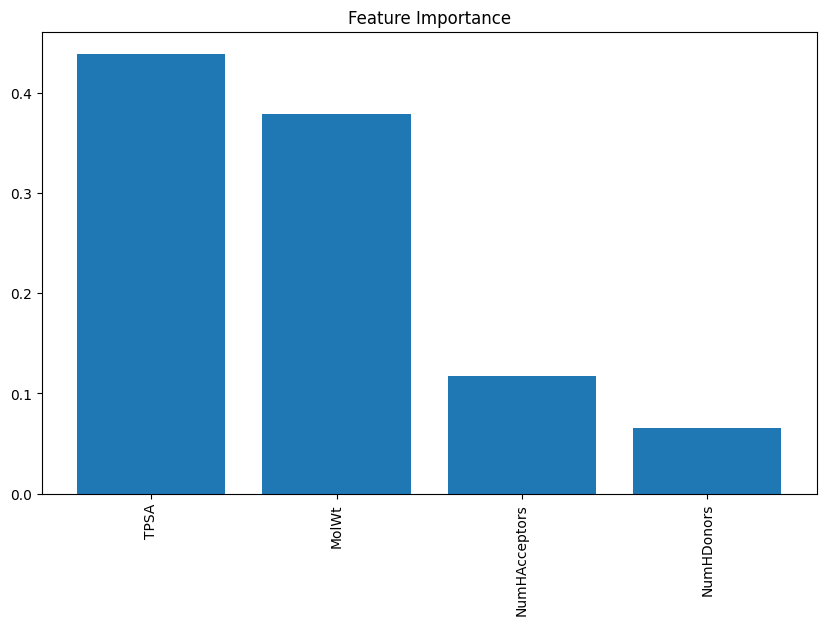

In [13]:
# Plot feature importance from the Random Forest model
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.title("Feature Importance")
plt.show()


In [14]:
# Perform Grid Search for hyperparameter optimization
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [15]:
# Train the final model using the best hyperparameters
final_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
final_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [17]:
#Evaluate the final model
print(f"Accuracy on Test Data: {accuracy_score(y_test, final_model.predict(X_test)):.2f}")
print("Classification Report:\n", classification_report(y_test, final_model.predict(X_test)))

Accuracy on Test Data: 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74       351
           1       0.81      0.82      0.82       493

    accuracy                           0.78       844
   macro avg       0.78      0.78      0.78       844
weighted avg       0.78      0.78      0.78       844



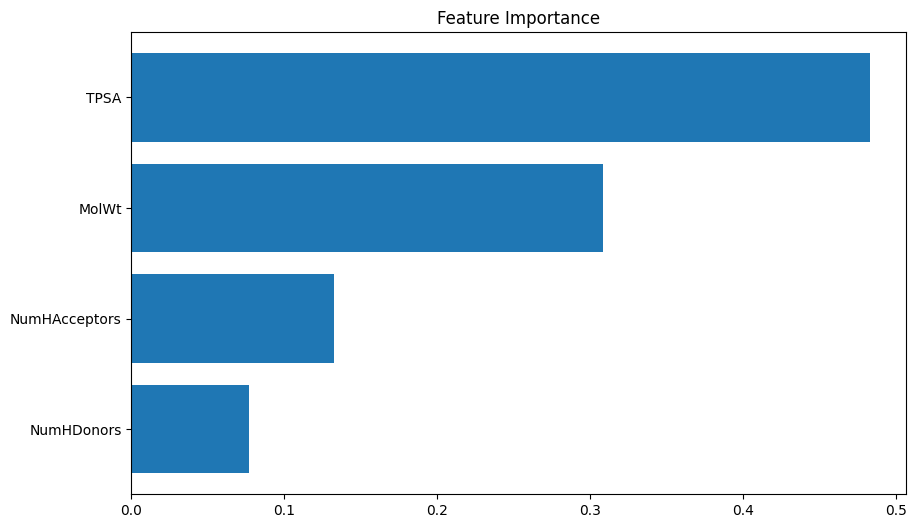

In [18]:
# Visualize feature importance for the final model
feature_importances = final_model.feature_importances_
sorted_indices = feature_importances.argsort()
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_indices])
plt.yticks(range(len(feature_importances)), [X.columns[i] for i in sorted_indices])
plt.title('Feature Importance')
plt.show()

In [19]:
# Perform k-fold cross-validation
cv_scores = cross_val_score(final_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")


Cross-Validation Scores: [0.76777251 0.76275208 0.76749703 0.77342823 0.7603796 ]
Mean Accuracy: 0.77 ± 0.00


In [20]:
# Perform bootstrap sampling for additional evaluation
X_bootstrap, y_bootstrap = resample(X, y, replace=True, random_state=42)
final_model.fit(X_bootstrap, y_bootstrap)
oob_data = set(range(len(y))) - set(X_bootstrap.index)
X_oob = X.iloc[list(oob_data)]
y_oob = y.iloc[list(oob_data)]
oob_predictions = final_model.predict(X_oob)
print(f"OOB Accuracy: {accuracy_score(y_oob, oob_predictions):.2f}")


OOB Accuracy: 0.73


In [21]:
# Apply SMOTE for handling imbalanced data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

/Users/vimshetsyan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/vimshetsyan/Library/Python/3.9/lib/python/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [22]:
# Add noise to features and evaluate model robustness
X_noisy = X + np.random.normal(0, 0.1, X.shape)
noisy_predictions = final_model.predict(X_noisy)
print(f"Accuracy on Noisy Data: {accuracy_score(y, noisy_predictions):.2f}")


Accuracy on Noisy Data: 0.85


In [47]:
# Example: Add noise to features and evaluate predictions
import numpy as np

X_noisy = X + np.random.normal(0, 0.1, X.shape)
noisy_predictions = final_model.predict(X_noisy)
accuracy_noisy = accuracy_score(y, noisy_predictions)
print(f"Accuracy on Noisy Data: {accuracy_noisy:.2f}")


Accuracy on Noisy Data: 0.85


In [23]:
# Display final feature importance scores
for name, importance in zip(X.columns, final_model.feature_importances_):
    print(f"{name}: {importance:.2f}")


MolWt: 0.33
NumHAcceptors: 0.14
NumHDonors: 0.08
TPSA: 0.45
